# Waveform classification

### Using F3 dataset

Let's look at waveform classification (e.g. see [this paper](https://csegrecorder.com/articles/view/seismic-waveform-classification-techniques-and-benefits)). 

## Load some seismic

F3-anomaly_cube.npy

- A seismic cube (numpy array format) with shape (651, 951, 188)
- 651 inlines, 951 xlines, and 188 time samples
- Start time is 250 ms
- End time is 1000 ms
- Sample interval is 4 ms
- inline range: 100 – 750 (we'll just use index positions 0 – 650) (651 inlines)
- xline range: 300 – 1250 (we'll just use index positions 0 – 950) (951 xlines)

Here's how to get the data on Mac or Linux:

    cd ../data
    ! wget https://geocomp.s3.amazonaws.com/F3_waveform_anomaly.zip
    ! unzip F3_waveform_anomaly.zip
    ! rm -rf F3_waveform_anomaly.zip
    cd -
    
On Windows, you can visit the URL (which will download the file) then move it to the `data` directory and unzip it.

In [1]:
import numpy as np

seismic = np.load('../data/F3_waveform_anomaly/F3_anomaly_cube.npy')

In [2]:
seismic.shape, seismic.dtype

((651, 951, 188), dtype('int8'))

Be warned:

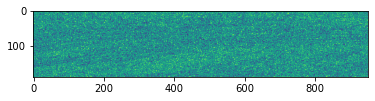

In [3]:
import matplotlib.pyplot as plt

plt.imshow(seismic[100].T**2)

So we have to be careful with 8-bit data!

We can define real-world cordinates of the seismic data using `extent=(0, 400, 4.0, 0)` in `imshow()`.

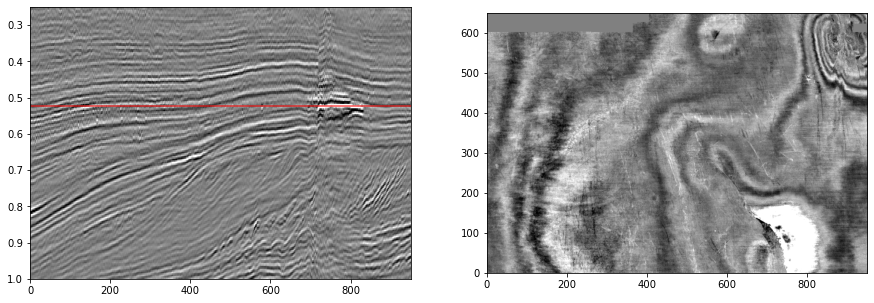

In [4]:
import matplotlib.pyplot as plt

inline = 100
extent = (0, 950, 1.0, 0.25)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 5))
ax0.imshow(seismic[inline].T, cmap='gray', extent=extent, aspect='auto')

# A slice through the bright spot.
tidx = 68
dt = 0.004
pos = tidx * dt + 0.25  # This is awkward!

ax0.axhline(pos, c='r', alpha=0.67)

ax1.imshow(seismic[:, :, tidx], cmap='gray', origin='lower')

plt.show()

## Intro to `xarray`

It's easy to make an amplitude map if we use `xarray` for both the seismic and the horizon.

`xarray` is basically `pandas` for n-dimensional data, not just 1D (`pandas.Series`) and 2D (`pandas.DataFrame`).

In [5]:
# Imagine that we have a GR log with made-up data:
data = [23, 20, 17, 26, 43, 56]

In [6]:
# Now say we have depths for these values in another list:
depths = [100, 101, 102, 103, 104, 105]

In [7]:
# Fine... but it's hard to look things up by depth:
data[depths.index(104)]

# There is a better way!

43

In [14]:
# xarray to the rescue!
import xarray as xr

x = xr.DataArray(data,
                 name='GR',
                 coords=[depths],
                 dims=['depth'],
                )

x

NameError: name 'data' is not defined

In [ ]:
x.plot()

# Notice how amazing this plot is.

In [ ]:
# Try some things:
x[2] * 100  # As expected.
x.loc[101.5:104.5]  # THIS IS AWESOME.
x.interp(depth=[102.7, 104.5, 1009], method='cubic')  # This is incredibly useful.

In [ ]:
new_depths = np.arange(100, 109.5, 0.5)
new_depths

In [ ]:
x_ = x.interp(depth=new_depths, method='cubic')  # NB Only linear or nearest for n-D arrays.
x_

In [ ]:
plt.plot(x.depth, x, 'ko-', ms=20)
plt.plot(x_.depth, x_, 'ro-')

## Resampling perdiodic signals

For resampling periodic signals like seismic data, it's probably a better idea to use one of the following:

 - [`scipy.signal.decimate`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.decimate.html) — to upsample.
 - [`scipy.signal.resample`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html) — to downsample (or upsample).
 
These functions take care of potential aliasing issues. Changing the sample interval changes the maximum frequency that can be represented in the data (the so-called Nyquist frequency), so we have to remove high frequencies before downsampling especially. 
 
For example:

In [5]:
_, _, Nt = seismic.shape
Nt

188

In [6]:
# Make a time basis for the data.
t = np.linspace(0, Nt * dt, Nt + 1) + 0.25
t

array([0.25 , 0.254, 0.258, 0.262, 0.266, 0.27 , 0.274, 0.278, 0.282,
       0.286, 0.29 , 0.294, 0.298, 0.302, 0.306, 0.31 , 0.314, 0.318,
       0.322, 0.326, 0.33 , 0.334, 0.338, 0.342, 0.346, 0.35 , 0.354,
       0.358, 0.362, 0.366, 0.37 , 0.374, 0.378, 0.382, 0.386, 0.39 ,
       0.394, 0.398, 0.402, 0.406, 0.41 , 0.414, 0.418, 0.422, 0.426,
       0.43 , 0.434, 0.438, 0.442, 0.446, 0.45 , 0.454, 0.458, 0.462,
       0.466, 0.47 , 0.474, 0.478, 0.482, 0.486, 0.49 , 0.494, 0.498,
       0.502, 0.506, 0.51 , 0.514, 0.518, 0.522, 0.526, 0.53 , 0.534,
       0.538, 0.542, 0.546, 0.55 , 0.554, 0.558, 0.562, 0.566, 0.57 ,
       0.574, 0.578, 0.582, 0.586, 0.59 , 0.594, 0.598, 0.602, 0.606,
       0.61 , 0.614, 0.618, 0.622, 0.626, 0.63 , 0.634, 0.638, 0.642,
       0.646, 0.65 , 0.654, 0.658, 0.662, 0.666, 0.67 , 0.674, 0.678,
       0.682, 0.686, 0.69 , 0.694, 0.698, 0.702, 0.706, 0.71 , 0.714,
       0.718, 0.722, 0.726, 0.73 , 0.734, 0.738, 0.742, 0.746, 0.75 ,
       0.754, 0.758,

Now we can apply the resampling. Adding samples (which is spectrally 'safer' than removing them) is equivalent to padding the spectrum with zeros and doing it in the frequency domain ensure that we end up with the same spectrum — not introducing new signal as we might with, say, linear interpolation.

In [7]:
import scipy.signal as ss

num_samples = 4 * Nt  # Number of new samples; NB last 3 samples will be extrapolated.

seismic_1ms, t_new = ss.resample(seismic, num=num_samples, t=t, axis=-1)

seismic_1ms.shape

(651, 951, 752)

BUT!

In [ ]:
seismic_1ms.dtype

In [ ]:
seismic_1ms.nbytes/1e6, seismic.nbytes/1e6

It's 3.7GB!

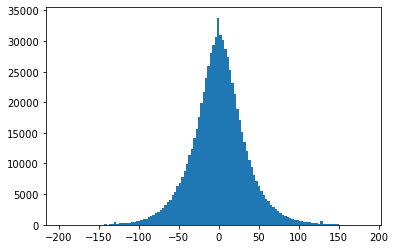

In [8]:
_ = plt.hist(seismic_1ms[100].ravel(), bins=127)

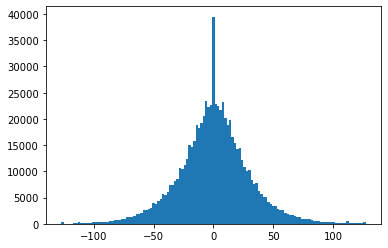

In [9]:
def bit_reduce(data, clip_perc=99):
    """
    Reduce bit-depth to 8-bit.
    """
    amax = np.percentile(abs(data), clip_perc)
    data = np.clip(data, -amax, amax)
    data = 127 * data / amax
    return data.astype(np.int8)

seismic_8 = bit_reduce(seismic_1ms, 99.95)

_ = plt.hist(seismic_8[100].ravel(), bins=127)

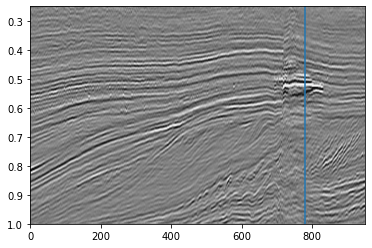

In [10]:
plt.imshow(seismic_8[inline].T, cmap='gray', extent=extent, aspect='auto')
plt.axvline(780)

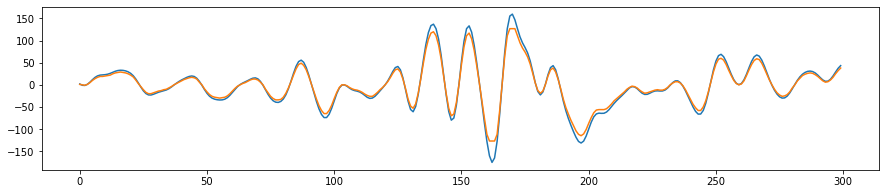

In [11]:
plt.figure(figsize=(15, 3))
plt.plot(seismic_1ms[inline, 780, 100:400])
plt.plot(seismic_8[inline, 780, 100:400])

In [12]:
seismic_1ms = seismic_8
del(seismic_8)

## The `map` trick

Suppose we want an integer

In [ ]:
nums = [1, 1.9, 2, 2.5, 3, 3.1416]

In [ ]:
[int(n) for n in nums]

In [ ]:
list(map(int, nums))

### EXERCISE

Make a `DataArray` for the upsampled seismic volume `seismic_1m`. Call it `seismic_`. Make sure to use upsampled time basis `t_new` for the time dimension.

In [ ]:
# YOUR CODE HERE



In [15]:
x, i, _ = map(np.arange, seismic.shape)

seismic_ = xr.DataArray(seismic_1ms,
                        name='amplitude',
                        coords=[x, i, t_new],
                        dims=['xline', 'inline', 'twt']
                       )

Now we can **almost** make the same display as before but with a bit different (and sometimes convenient) syntax:

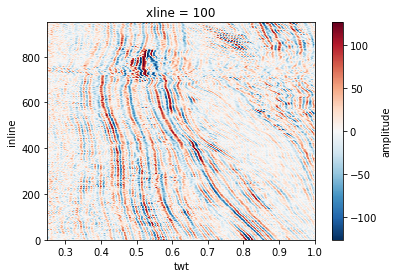

In [16]:
seismic_[inline].plot()

With a bit of modification it's perfect:

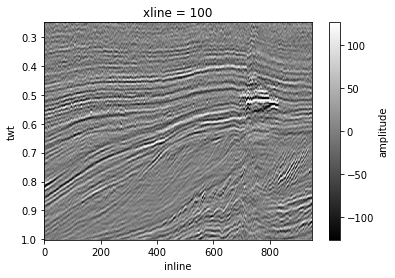

In [17]:
seismic_[inline].T.plot.imshow(origin='upper', cmap='gray')

## Load a horizon
This horizon has the same inline and xline dimensions as the seismic

In [2]:
import numpy as np

ds = np.DataSource('../data/')

data = np.load(ds.open('https://geocomp.s3.amazonaws.com/data/F3_horizon.npy', mode='rb'))

data.shape

(651, 951)

In [19]:
np.amin(sf), np.amax(sf)

(0.41542801261, 0.86045861244)

The `sf` array as values corresponding to two-way travel time (in seconds). Note that we'll flip the colorbar so that the shallow values are brighter colours.

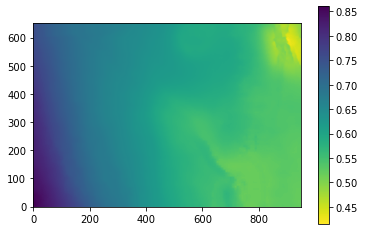

In [20]:
plt.imshow(sf, origin='lower', cmap='viridis_r')
plt.colorbar()

Let's look at the seismic and the horizon sliced along inline 100. This only works as expected if we get the pass the real physical extents to the `extent` keyword in the `imshow()` function.

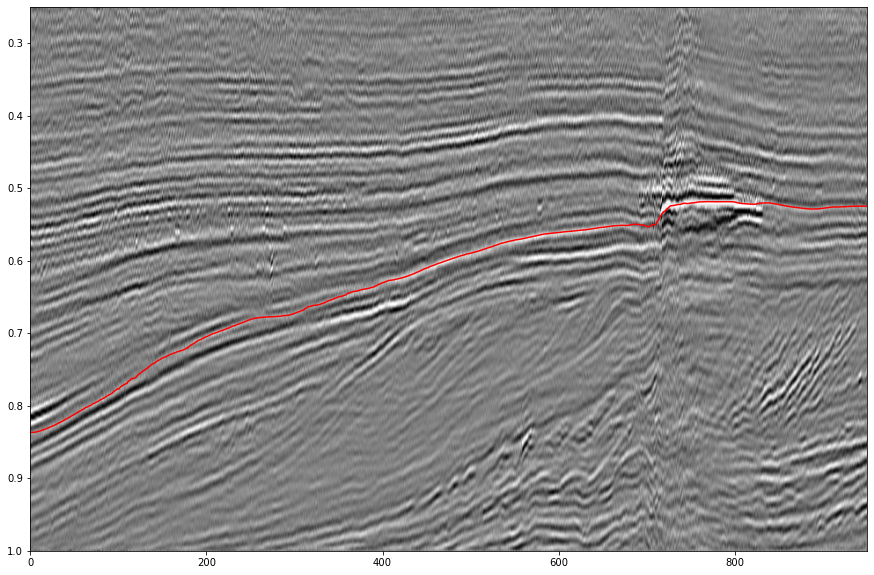

In [21]:
inline = 100
extent = [0, 950, 1.0, 0.25]

plt.figure(figsize=(15, 10))
plt.imshow(seismic_[inline].T, cmap='gray', extent=extent, aspect='auto')
plt.plot(sf[inline], c='r')

The next question you might have is, "How do I make an amplitude map?". Good question! The easiest way to do it is with `xarray`, so let's make an `xarray` for the horizon too.

### EXERCISE

Try making an `xarray.DataArray` for the horizon too. Call it `sf_`.

In [ ]:
# YOUR CODE HERE



In [22]:
sf_ = xr.DataArray(sf,
                   name='twt',
                   coords=[x, i],
                   dims=['xline', 'inline'],
                  )

This plots nicely with the seismic:

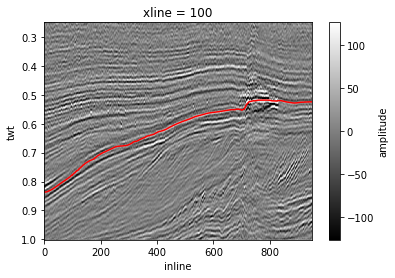

In [23]:
seismic_[inline].T.plot.imshow(origin='upper', cmap='gray')
sf_[inline].plot(c='r')

## Amplitude slice

One of the best features of `xarray` is multi-dimensional interpolation with very little code:

In [24]:
amp_ = seismic_.interp(xline=sf_.xline, inline=sf_.inline, twt=sf_)

Let's make a nicely-decorated map of these amplitudes along the horizon

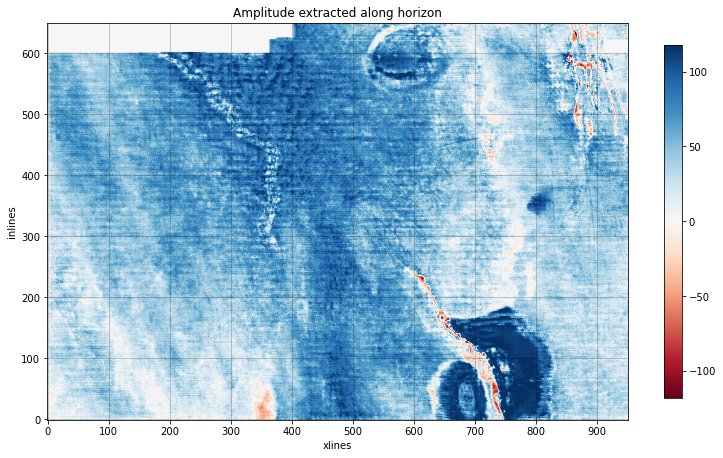

In [25]:
ma = np.percentile(amp_, 99)

plt.figure(figsize=(13, 13))
plt.imshow(amp_, origin='lower', cmap='RdBu', vmin=-ma, vmax=ma, aspect='equal')
plt.xticks(np.arange(0, amp_.shape[0], 100))
plt.xticks(np.arange(0, amp_.shape[1], 100))
plt.grid(alpha=0.25, c='k')
plt.colorbar(shrink=0.5)
plt.xlabel('xlines')
plt.ylabel('inlines')
plt.title('Amplitude extracted along horizon')
plt.show()

## Extract flattened subcube

Let's extract the data around the horizon.
This is where the finer time sampling will serve us well. Otherwise we'll end up with a jagged window, because (as far as I can tell) we can only select whole time samples. Unless someone can find a way to combine the `.interp()` with `.where()`.

In [26]:
half_window = 0.020  # 20 milliseconds

In [27]:
cond = (sf_ - half_window < seismic_.twt) & (seismic_.twt < sf_ + half_window)

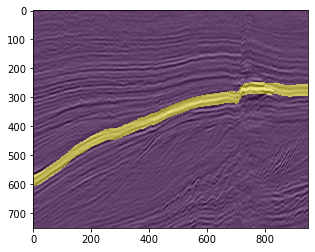

In [28]:
plt.imshow(seismic_[inline].T, origin='upper', cmap='gray')
plt.imshow(cond.T[:, inline, :].T, origin='upper', alpha=0.5, interpolation='none')

Now we can select the seismic data only within that zone, and all other elements will be set to `nans`

In [29]:
zone = seismic_.where(cond)

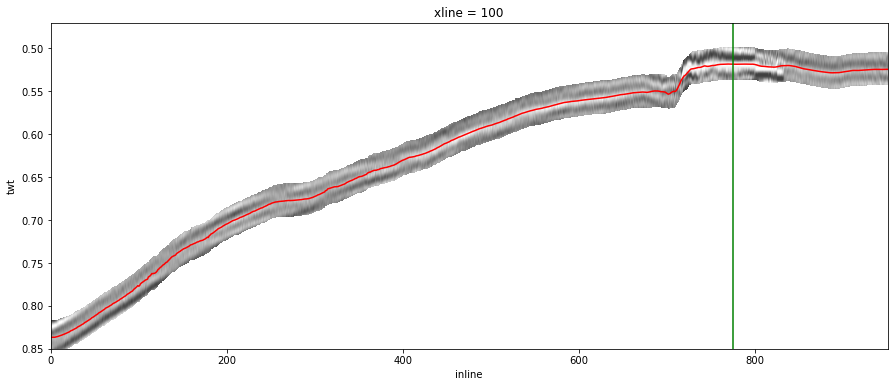

In [30]:
target_tr = 775
zone_slice = zone[inline, :, :]

plt.figure(figsize=(15, 6))
plt.imshow(zone_slice.T, aspect='auto', extent=extent, alpha=0.75, cmap='gray')
sf_[inline].plot(color='r', alpha=1.0, xincrease=True)
plt.ylim(0.85, 0.47)
plt.axvline(target_tr, c='g')

Now we'd like to get those traces in a volume, without all the NaNs.

In [31]:
nilines, nxlines, nt = seismic_.shape

And we can extract only the non-NaN values as an array. This will be a subvolume flattened on the horizon:

In [32]:
traces = seismic_1ms[~np.isnan(zone)].reshape(nilines, nxlines, -1)
# ^ can't use 3D boolean indexing on xarray for some reason

traces.shape

(651, 951, 40)

In [33]:
# Target inline, xline
ti, tx = 100, 775

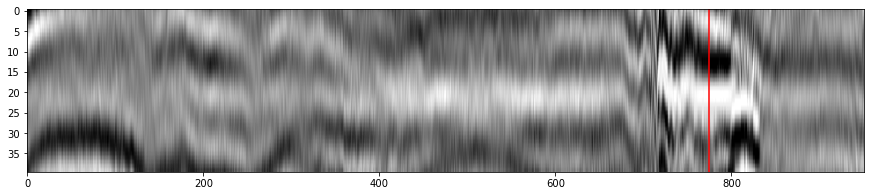

In [34]:
plt.figure(figsize=(15, 3))
plt.imshow(traces[ti].T, aspect='auto', cmap='gray')
plt.axvline(tx, c='r')

Let's look at the middle of the slab — the amplitude map of the horizon:

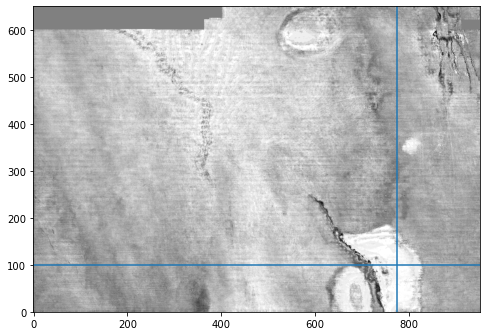

In [35]:
plt.figure(figsize=(8,6))
plt.imshow(traces[:, :, traces.shape[-1] // 2], origin='lower', cmap='gray')
plt.axhline(ti)
plt.axvline(tx)

## Wavelet similarity

Let's find the similarity to the trace at inline 100, xline 775 (for example).

### EXERCISE

Like `np.convolve`, `np.correlate` is a 1D algorithm. Can you implement it here using `np.apply_along_axis()`?

An alternative would be using `scipy.signal.correlate()`, in which case you need to reshape `target` to have the same number of dimensions as `traces`.

**Note!** You need to use `target.astype(float)` to get correlate to return something useful.

**Hint:** try correlating just one trace to start with.

In [ ]:
# YOUR CODE HERE
target = traces[ti, tx]



(39.0, 0.0)

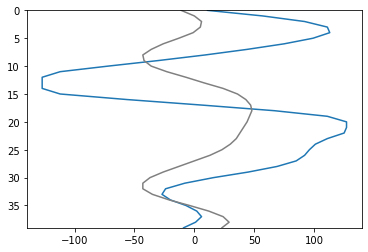

In [51]:
target = traces[ti, tx]
tr = traces[ti, 400]
tshort = np.arange(target.size)

plt.plot(target, tshort)
plt.plot(tr, tshort, c='grey')
plt.ylim(tshort[-1], tshort[0])

In [52]:
# Gotcha.
traces.dtype

dtype('int8')

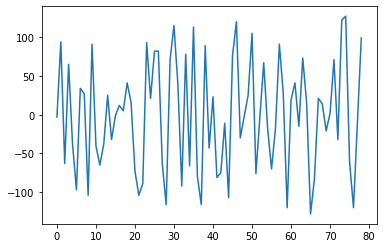

In [54]:
# So this produces garbage:
plt.plot(np.correlate(target, tr, mode='full'))

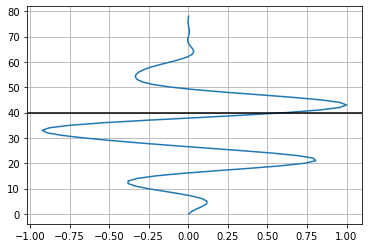

In [31]:
# The correlation of two signals in "full" mode.
# Shift one w.r.t. the other
corr = np.correlate(target.astype(float), tr, mode='full')
corr /= corr.max()  # Normalize to 1.

plt.plot(corr, np.arange(corr.size))
plt.grid()
plt.axhline(40, c='k')

# Max correlation occurs when you move up a few samples.

In [35]:
# The signals are the same length, so 'valid' returns one number.
np.correlate(target.astype(float), tr, mode='valid')

# This is what we want — we don't care about different lags,
# because we provided the seismic horizon.

array([35690.32138251])

In [55]:
params = dict(axis=-1, v=target.astype(float), mode='valid')
corr = [np.apply_along_axis(np.correlate, arr=line, **params) for line in traces]
corr = np.squeeze(np.array(corr))
corr /= corr.max()

corr.shape, seismic.shape

((651, 951), (651, 951, 188))

Let's look at the result:

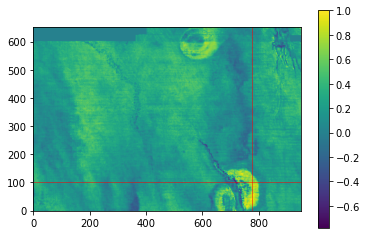

In [64]:
plt.imshow(corr, origin='lower')
plt.axhline(ti, c='r', lw=0.5)
plt.axvline(tx, c='r', lw=0.5)
plt.colorbar()

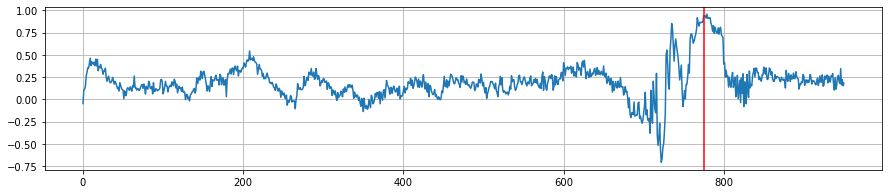

In [61]:
plt.figure(figsize=(15,3))
plt.plot(corr[ti, :])
plt.axvline(tx, c='r')
plt.grid()

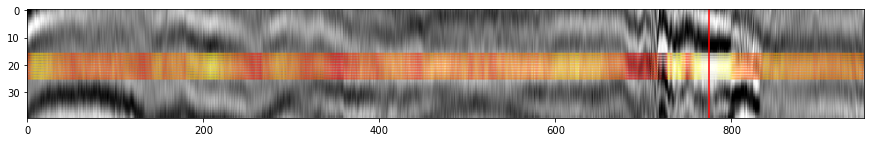

In [66]:
middle = traces.shape[-1] // 2
inlines = np.arange(seismic.shape[1])

plt.figure(figsize=(15, 2))
plt.imshow(traces[ti].T, aspect='auto', cmap='gray')
for i in np.arange(middle - 5, middle + 5):
    plt.scatter(inlines, i + np.ones_like(inlines), c=corr[inline], cmap='hot', s=3, alpha=0.2)
plt.axvline(tx, c='r')

Clearly, the amplitude dominates the picture.

## Waveform classifier

Let's cluster the waveforms and try to emulate Stratimagic.

In [36]:
from sklearn.cluster import KMeans

n = 10
clu = KMeans(n_clusters=n)
clu.fit(traces.reshape(-1, traces.shape[-1]))
clu.labels_

array([2, 5, 2, ..., 3, 3, 7], dtype=int32)

Now we can make a plot:

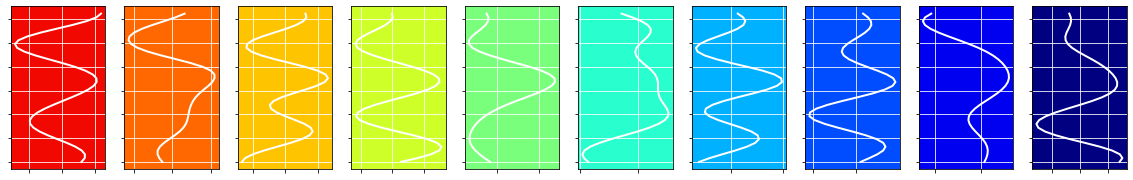

In [37]:
fig, axs = plt.subplots(ncols=n, figsize=(2*n, 3))
t = np.arange(0, traces.shape[-1] * dt, dt)
for i, (ax, tr) in enumerate(zip(axs, clu.cluster_centers_)):
    ax.set_facecolor(plt.get_cmap('jet_r')((i+1)/n))
    ax.plot(tr, t, 'w', lw=2)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(color='w')

In [38]:
labels = (1 - np.isnan(seismic_.where(cond))) * (clu.labels_.reshape(nilines, -1)[:, :, None] + 1)
labels = labels.data.astype(np.float)
labels[labels < 1] = np.nan

<ipython-input-38-89124a0e081e>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = labels.data.astype(np.float)


In [42]:
from ipywidgets import interact

@interact(opacity=(0,1,0.1))
def show(opacity):
    plt.figure(figsize=(12, 5))
    plt.imshow(seismic_1ms[inline].T, cmap='gray')
    plt.imshow(labels[inline].T, cmap='jet_r', aspect='auto', alpha=opacity, interpolation='none')
    plt.axvline(775)

interactive(children=(FloatSlider(value=0.0, description='opacity', max=1.0), Output()), _dom_classes=('widget…

Text(548, 622, 'F03-2')

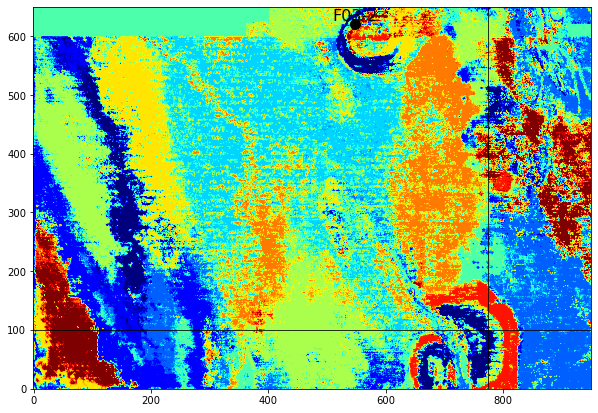

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(clu.labels_.reshape(651, -1), cmap='jet_r', origin='lower')
plt.axhline(inline, c='k', alpha=0.8, lw=1)
plt.axvline(775, c='k', alpha=0.8, lw=1)
plt.scatter([548], [622], c='k', s=100 )
plt.text(548, 622, 'F03-2', ha='center', va='bottom', size=16 )


## Other clustering methods

In a terminal or Anaconda Prompt with your environment activated, do:

`conda install -c conda-forge umap-learn`

In [ ]:
from umap import UMAP

In [ ]:

umap = UMAP()

embedding = umap.fit_transform(traces.reshape(-1, traces.shape[-1]))

The embedding is independent of the k-means labels, but we can compare them:

In [ ]:
plt.scatter(*embedding.T, c=clu.labels_, cmap='jet_r', alpha=0.05, s=2)

Ways to extend this:

- Use some optimization for `n_clusters`, e.g. see https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set and https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
- Use other similarity measures than cross-correlation, such as L1 or L2 norms, or semblance.
- Use another clustering algorithm, eg agglomerative clustering, DBSCAN or UMAP. Agglomerative solutions are interesting because you can choose the granularity of the clusters after training (this facies contains these subfacies).
- There is some very cool stuff in [`tslearn`](https://tslearn.readthedocs.io/), including algorithms for clustering timeseries, [like this one](https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html).
- Normalize the amplitudes to lessen the effect of amplitude variance.
- Do _something clever_ to allow the window length to vary (e.g. between two horizons). E.g. extract window-independent features from the traces (RMS amplitude, number of peaks, etc), map points using dynamic time warping, or see work by [Song et al. (2019)](https://doi.org/10.1190/segam2019-3208031.1).
- We have 100 samples, but they are highly correlated. Apply dimensionality reduction (e.g. simple downsampling, or PCA) before clustering.
- Allow the user to choose some locations (eg at wells), then use supervised learning to classify the traces.

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2021</p>
</div>